# Linear model 
$\Phi: X W + B + \epsilon$

In [7]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random

### Generate random numbers

In [17]:
num_inputs = 2
num_examples = 1000
true_w = nd.array([2, -3.4])
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)

In [18]:
print(features.shape)
print(true_w.shape)

(1000, 2)
(2,)


### Visualization

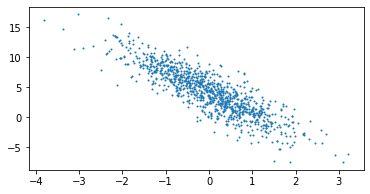

In [19]:
plt.figure(figsize=(6,3))
plt.scatter(features[:,1].asnumpy(), labels.asnumpy(),1)

### Reading data in batches

In [26]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i:min(i+batch_size, num_examples)])
        yield features.take(j), labels.take(j)
        # 'take' returns the corresponding elements on the indices

### Initialize model parameters

In [21]:
w = nd.random_normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1,))
print(w,b)


[[ 0.01005177]
 [-0.00868195]]
<NDArray 2x1 @cpu(0)> 
[0.]
<NDArray 1 @cpu(0)>


### Attach gradients: to compute gradients respect to w and b

In [22]:
w.attach_grad()
b.attach_grad()

### Define the linear model

In [23]:
def linreg(X,w,b):
    return nd.dot(X,w)+b

### Define the loss function

In [24]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### Define the optimization algorithm

In [25]:
lr = 0.03  # learning rate
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size
# we divide by batch_size to avoid adding to the loss function 

### Training loop using Gluon

In [12]:
batch_size = 5
num_epochs = 3 # number of iterations
net = linreg  # Our linear model
loss = squared_loss # Our loss function

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y) # Minibatch loss in X and y
        l.backward() # Compute gradient on l with parameter [w,b]
        sgd([w,b], lr, batch_size)  # Update parameters using their gradient
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch+1, train_l.mean().asnumpy()))

epoch 1, loss 0.000124
epoch 2, loss 0.000048
epoch 3, loss 0.000049


### Evaluate the trained model

In [13]:
print("Error in estimating w", true_w - w.reshape(true_w.shape))
print("Error in estimating b", true_b - b)

Error in estimating w 
[0.00013459 0.00045109]
<NDArray 2 @cpu(0)>
Error in estimating b 
[0.00067043]
<NDArray 1 @cpu(0)>


## Using Gluon

In [14]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random

### Generate random numbers

In [15]:
num_inputs = 2
num_examples = 1000
true_w = nd.array([2, -3.4])
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)

### Reading data in batches

In [16]:
from mxnet.gluon import data as gdata

batch_size = 10
# Combine the features and labels of the training data
dataset = gdata.ArrayDataset(features, labels)
# Randomly reading mini-batches
data_iter = gdata.DataLoader(dataset, batch_size, shuffle=True)

### Define the linear model

In [17]:
from mxnet.gluon import nn
net = nn.Sequential()
net.add(nn.Dense(1))

### Initialize model parameters

In [18]:
from mxnet import init
net.initialize(init.Normal(sigma=0.01))

### Define the loss function

In [19]:
from mxnet.gluon import loss as gloss
loss = gloss.L2Loss() # This is the squared loss defined previously

### Define the optimization algorithm

In [21]:
from mxnet import gluon
lr = 0.03  # learning rate
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})

### Training loop

In [24]:
num_epochs = 3 # number of iterations

for epoch in range(num_epochs):
    for X, y in data_iter:
        with autograd.record():
            l = loss(net(X), y)
        l.backward() # Compute gradient on l with parameter [w,b]
        trainer.step(batch_size)
    train_l = loss(net(features), labels)
    print('epoch %d, loss %f' % (epoch+1, train_l.mean().asnumpy()))

epoch 1, loss 0.000049
epoch 2, loss 0.000049
epoch 3, loss 0.000049


### Evaluate the trained model

In [25]:
pdict = net.collect_params()
w = pdict['dense0_weight'].data()
b = pdict['dense0_bias'].data()
print("Error in estimating w", true_w - w.reshape(true_w.shape))
print("Error in estimating b", true_b - b)

Error in estimating w 
[-0.00021887  0.00022817]
<NDArray 2 @cpu(0)>
Error in estimating b 
[-4.1484833e-05]
<NDArray 1 @cpu(0)>
